# Notebook 4

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from pathlib import Path

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
print('✓ Libraries loaded')

✓ Libraries loaded


## 2. Load and Merge Data

In [2]:
# File paths
WEATHER_CSV = Path('openmeteo_weather_data_daily.csv')
CLEAR_CSV = Path('pvlib_clear_sky_daily_features.csv')

# Load weather data
weather = pd.read_csv(WEATHER_CSV, parse_dates=['time'])
weather = weather.rename(columns={'time': 'time_weather'})
weather['date'] = weather['time_weather'].dt.date

# Load clear-sky features
clear = pd.read_csv(CLEAR_CSV)
if 'Unnamed: 0' in clear.columns:
    clear = clear.rename(columns={'Unnamed: 0': 'time'})
clear['time_clear'] = pd.to_datetime(clear['time'])
clear['date'] = clear['time_clear'].dt.date

# Merge on date
merged = pd.merge(weather, clear, on='date', how='inner')

# Unit conversion: Wh → kWh
merged['actual_ghi_kwh'] = merged['solar_ghi_sum'] / 1000.0

# Compute clearness index
merged['Kt'] = merged['actual_ghi_kwh'] / merged['clear_sky_ghi_kwh']

# Clean data
merged = merged.sort_values('time_weather').reset_index(drop=True)
merged = merged[(merged['Kt'] > 0) & (merged['Kt'] <= 1.2)]
merged = merged.dropna()

print(f'✓ Merged dataset: {len(merged)} rows')
print(f'✓ Date range: {merged["time_weather"].min()} to {merged["time_weather"].max()}')
merged.head()

✓ Merged dataset: 1431 rows
✓ Date range: 2022-01-01 00:00:00 to 2025-12-01 00:00:00


,time_weather,weather_code,temperature_max,temperature_min,precipitation,wind_speed_max,wind_gust_max,solar_ghi_sum,date,time,clear_sky_ghi_wh,clear_sky_dni_wh,solar_zenith_mean,solar_azimuth_mean,air_mass_mean,clear_sky_ghi_kwh,clear_sky_dni_kwh,time_clear,actual_ghi_kwh,Kt
0,2022-01-01,55,31.7,22.5,2.8,15.0,32.4,18.22,2022-01-01,2022-01-01 00:00:00+05:30,6135.474240,7665.141651,94.260002,180.015442,5.227719,6.135474,7.665142,2022-01-01 00:00:00+05:30,0.01822,0.002970
1,2022-01-02,61,31.1,22.8,2.7,16.9,38.9,18.03,2022-01-02,2022-01-02 00:00:00+05:30,6148.104174,7685.541531,94.250472,180.017749,5.090355,6.148104,7.685542,2022-01-02 00:00:00+05:30,0.01803,0.002933
2,2022-01-03,55,30.9,22.6,2.4,16.8,41.0,17.59,2022-01-03,2022-01-03 00:00:00+05:30,6161.312396,7706.222931,94.240097,180.020067,4.961359,6.161312,7.706223,2022-01-03 00:00:00+05:30,0.01759,0.002855
3,2022-01-04,55,30.5,22.4,1.1,21.0,43.9,18.51,2022-01-04,2022-01-04 00:00:00+05:30,6175.093076,7727.193450,94.228875,180.022396,4.840490,6.175093,7.727193,2022-01-04 00:00:00+05:30,0.01851,0.002998
4,2022-01-05,53,29.4,23.0,2.0,17.2,38.2,17.08,2022-01-05,2022-01-05 00:00:00+05:30,6189.439925,7748.461487,94.216802,180.024739,4.727414,6.189440,7.748461,2022-01-05 00:00:00+05:30,0.01708,0.002760


## 3. Feature Engineering with Weather Lag Features

**New approach:** Add 3-day lag features for temperature and precipitation to capture weather pattern persistence.

In [3]:
df_feat = merged.copy()

# Temporal features
if not pd.api.types.is_datetime64_any_dtype(df_feat['time_weather']):
    df_feat['time_weather'] = pd.to_datetime(df_feat['time_weather'])
    
doy = df_feat['time_weather'].dt.dayofyear
period = 365.25
df_feat['doy_sin'] = np.sin(2 * np.pi * doy / period)
df_feat['doy_cos'] = np.cos(2 * np.pi * doy / period)

# Kt lag features (original)
df_feat['Kt_lag1'] = df_feat['Kt'].shift(1)
df_feat['Kt_lag2'] = df_feat['Kt'].shift(2)
df_feat['Kt_lag3'] = df_feat['Kt'].shift(3)
df_feat['Kt_roll3'] = df_feat['Kt'].rolling(window=3, min_periods=3).mean()

# NEW: Temperature lag features (1-3 days)
for lag in [1, 2, 3]:
    df_feat[f'temperature_max_lag{lag}'] = df_feat['temperature_max'].shift(lag)
    df_feat[f'temperature_min_lag{lag}'] = df_feat['temperature_min'].shift(lag)

# NEW: Temperature rolling mean (3-day)
df_feat['temperature_max_roll3'] = df_feat['temperature_max'].shift(1).rolling(window=3).mean()
df_feat['temperature_min_roll3'] = df_feat['temperature_min'].shift(1).rolling(window=3).mean()

# NEW: Precipitation lag features (1-3 days)
for lag in [1, 2, 3]:
    df_feat[f'precipitation_lag{lag}'] = df_feat['precipitation'].shift(lag)

# NEW: Precipitation rolling sum (3-day total)
df_feat['precipitation_roll3_sum'] = df_feat['precipitation'].shift(1).rolling(window=3).sum()

# Drop NaN values
df_feat = df_feat.dropna().reset_index(drop=True)

print(f'✓ After feature engineering: {len(df_feat)} rows × {len(df_feat.columns)} columns')
print(f'✓ Lost {len(merged) - len(df_feat)} rows due to lag/rolling window')
print(f'\n✓ New weather lag features added:')
print('  - Temperature max/min lag 1-3 days')
print('  - Temperature max/min 3-day rolling mean')
print('  - Precipitation lag 1-3 days')
print('  - Precipitation 3-day rolling sum')
df_feat.head()

✓ After feature engineering: 1428 rows × 38 columns
✓ Lost 3 rows due to lag/rolling window

✓ New weather lag features added:
  - Temperature max/min lag 1-3 days
  - Temperature max/min 3-day rolling mean
  - Precipitation lag 1-3 days
  - Precipitation 3-day rolling sum


,time_weather,weather_code,temperature_max,temperature_min,precipitation,wind_speed_max,wind_gust_max,solar_ghi_sum,date,time,clear_sky_ghi_wh,clear_sky_dni_wh,solar_zenith_mean,solar_azimuth_mean,air_mass_mean,clear_sky_ghi_kwh,clear_sky_dni_kwh,time_clear,actual_ghi_kwh,Kt,doy_sin,doy_cos,Kt_lag1,Kt_lag2,Kt_lag3,Kt_roll3,temperature_max_lag1,temperature_min_lag1,temperature_max_lag2,temperature_min_lag2,temperature_max_lag3,temperature_min_lag3,temperature_max_roll3,temperature_min_roll3,precipitation_lag1,precipitation_lag2,precipitation_lag3,precipitation_roll3_sum
0,2022-01-04,55,30.5,22.4,1.1,21.0,43.9,18.51,2022-01-04,2022-01-04 00:00:00+05:30,6175.093076,7727.193450,94.228875,180.022396,4.840490,6.175093,7.727193,2022-01-04 00:00:00+05:30,0.01851,0.002998,0.068755,0.997634,0.002855,0.002933,0.002970,0.002928,30.9,22.6,31.1,22.8,31.7,22.5,31.233333,22.633333,2.4,2.7,2.8,7.9
1,2022-01-05,53,29.4,23.0,2.0,17.2,38.2,17.08,2022-01-05,2022-01-05 00:00:00+05:30,6189.439925,7748.461487,94.216802,180.024739,4.727414,6.189440,7.748461,2022-01-05 00:00:00+05:30,0.01708,0.002760,0.085906,0.996303,0.002998,0.002855,0.002933,0.002871,30.5,22.4,30.9,22.6,31.1,22.8,30.833333,22.600000,1.1,2.4,2.7,6.2
2,2022-01-06,51,31.6,22.8,0.1,19.5,42.5,18.57,2022-01-06,2022-01-06 00:00:00+05:30,6204.346057,7770.035877,94.203873,180.027097,4.621737,6.204346,7.770036,2022-01-06 00:00:00+05:30,0.01857,0.002993,0.103031,0.994678,0.002760,0.002998,0.002855,0.002917,29.4,23.0,30.5,22.4,30.9,22.6,30.266667,22.666667,2.0,1.1,2.4,5.5
3,2022-01-07,53,33.0,22.2,1.5,13.6,32.0,20.62,2022-01-07,2022-01-07 00:00:00+05:30,6219.803834,7791.925498,94.190085,180.029468,4.523032,6.219804,7.791925,2022-01-07 00:00:00+05:30,0.02062,0.003315,0.120126,0.992759,0.002993,0.002760,0.002998,0.003023,31.6,22.8,29.4,23.0,30.5,22.4,30.500000,22.733333,0.1,2.0,1.1,3.2
4,2022-01-08,51,31.5,21.4,0.2,16.8,36.7,20.23,2022-01-08,2022-01-08 00:00:00+05:30,6235.804766,7814.138887,94.175433,180.031856,4.430855,6.235805,7.814139,2022-01-08 00:00:00+05:30,0.02023,0.003244,0.137185,0.990545,0.003315,0.002993,0.002760,0.003184,33.0,22.2,31.6,22.8,29.4,23.0,31.333333,22.666667,1.5,0.1,2.0,3.6


## 4. Define Features and Target

In [4]:
FEATURES = [
    # Current weather variables
    'weather_code', 'temperature_max', 'temperature_min', 
    'precipitation', 'wind_speed_max', 'wind_gust_max',
    
    # Clear-sky features
    'clear_sky_ghi_kwh', 'clear_sky_dni_kwh',
    'solar_zenith_mean', 'air_mass_mean',
    
    # Temporal features
    'doy_sin', 'doy_cos',
    
    # Kt history features
    'Kt_lag1', 'Kt_lag2', 'Kt_lag3', 'Kt_roll3',
    
    # NEW: Temperature lag features
    'temperature_max_lag1', 'temperature_max_lag2', 'temperature_max_lag3',
    'temperature_min_lag1', 'temperature_min_lag2', 'temperature_min_lag3',
    'temperature_max_roll3', 'temperature_min_roll3',
    
    # NEW: Precipitation lag features
    'precipitation_lag1', 'precipitation_lag2', 'precipitation_lag3',
    'precipitation_roll3_sum'
]

TARGET = 'actual_ghi_kwh'

X = df_feat[FEATURES]
y = df_feat[TARGET]

print(f'✓ Total features: {len(FEATURES)}')
print(f'✓ Original features: 15')
print(f'✓ New weather lag features: {len(FEATURES) - 15}')
print(f'✓ Dataset shape: X={X.shape}, y={y.shape}')

✓ Total features: 28
✓ Original features: 15
✓ New weather lag features: 13
✓ Dataset shape: X=(1428, 28), y=(1428,)


## 5. Train/Validation/Test Split

In [5]:
n = len(df_feat)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

print(f'✓ Train set: {len(X_train)} samples ({len(X_train)/n*100:.1f}%)')
print(f'✓ Validation set: {len(X_val)} samples ({len(X_val)/n*100:.1f}%)')
print(f'✓ Test set: {len(X_test)} samples ({len(X_test)/n*100:.1f}%)')

✓ Train set: 999 samples (70.0%)
✓ Validation set: 214 samples (15.0%)
✓ Test set: 215 samples (15.1%)


## 6. Train XGBoost Model

In [6]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
print('✓ Model training complete')

✓ Model training complete


## 7. Evaluate Model Performance

In [7]:
# Validation metrics
val_pred = model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_pred)
val_r2 = r2_score(y_val, val_pred)
val_mape = np.mean(np.abs((y_val - val_pred) / y_val)) * 100
val_acc_10 = np.mean(np.abs((y_val - val_pred) / y_val) <= 0.10) * 100
val_acc_20 = np.mean(np.abs((y_val - val_pred) / y_val) <= 0.20) * 100

print('='*60)
print('VALIDATION SET PERFORMANCE')
print('='*60)
print(f'MAE:              {val_mae:.4f} kWh/m²')
print(f'R² Score:         {val_r2:.3f}')
print(f'MAPE:             {val_mape:.2f}%')
print(f'Accuracy (±10%):  {val_acc_10:.2f}%')
print(f'Accuracy (±20%):  {val_acc_20:.2f}%')

# Test metrics
test_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
test_mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
test_acc_10 = np.mean(np.abs((y_test - test_pred) / y_test) <= 0.10) * 100
test_acc_20 = np.mean(np.abs((y_test - test_pred) / y_test) <= 0.20) * 100

print('\n' + '='*60)
print('TEST SET PERFORMANCE')
print('='*60)
print(f'MAE:              {test_mae:.4f} kWh/m²')
print(f'R² Score:         {test_r2:.3f}')
print(f'MAPE:             {test_mape:.2f}%')
print(f'Accuracy (±10%):  {test_acc_10:.2f}%')
print(f'Accuracy (±20%):  {test_acc_20:.2f}%')
print('='*60)

VALIDATION SET PERFORMANCE
MAE:              0.0010 kWh/m²
R² Score:         0.919
MAPE:             7.83%
Accuracy (±10%):  79.44%
Accuracy (±20%):  92.99%

TEST SET PERFORMANCE
MAE:              0.0010 kWh/m²
R² Score:         0.871
MAPE:             9.79%
Accuracy (±10%):  81.40%
Accuracy (±20%):  94.88%


## 8. Feature Importance Analysis

Feature Importance (Top 20):
Kt_roll3                       0.2492
temperature_max                0.2434
precipitation                  0.1107
weather_code                   0.0311
wind_gust_max                  0.0238
temperature_max_lag2           0.0228
clear_sky_ghi_kwh              0.0227
wind_speed_max                 0.0223
doy_sin                        0.0214
solar_zenith_mean              0.0210
clear_sky_dni_kwh              0.0199
temperature_max_roll3          0.0194
Kt_lag2                        0.0182
temperature_min_roll3          0.0177
doy_cos                        0.0168
temperature_min_lag2           0.0145
Kt_lag1                        0.0130
temperature_max_lag1           0.0126
precipitation_lag2             0.0126
precipitation_roll3_sum        0.0121


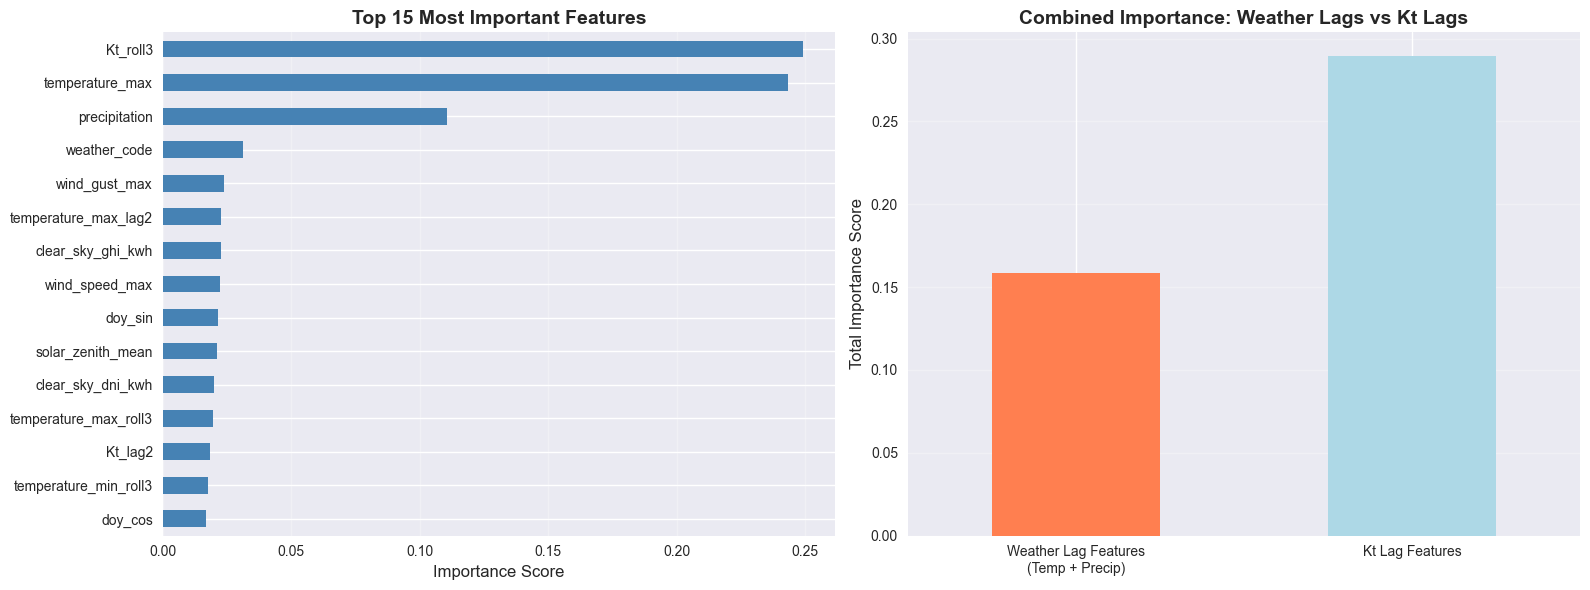


✓ Weather lag features total importance: 0.1583
✓ Kt lag features total importance: 0.2893


In [8]:
importance = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)

print('Feature Importance (Top 20):')  
print('='*60)
for feat, imp in importance.head(20).items():
    print(f'{feat:30s} {imp:.4f}')

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# All features
importance.head(15).sort_values().plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
ax1.set_xlabel('Importance Score', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

# Compare weather lag features vs Kt lag features
weather_lag_features = [f for f in FEATURES if any(x in f for x in ['temperature_', 'precipitation_']) and ('lag' in f or 'roll' in f)]
kt_lag_features = [f for f in FEATURES if 'Kt_' in f]

weather_lag_imp = importance[weather_lag_features].sum()
kt_lag_imp = importance[kt_lag_features].sum()

comparison = pd.Series({
    'Weather Lag Features\n(Temp + Precip)': weather_lag_imp,
    'Kt Lag Features': kt_lag_imp
})

comparison.plot(kind='bar', ax=ax2, color=['coral', 'lightblue'])
ax2.set_title('Combined Importance: Weather Lags vs Kt Lags', fontsize=14, fontweight='bold')
ax2.set_ylabel('Total Importance Score', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f'\n✓ Weather lag features total importance: {weather_lag_imp:.4f}')
print(f'✓ Kt lag features total importance: {kt_lag_imp:.4f}')

## 9. Comparison with Original Model

Compare this model (with weather lag features) against the original baseline model.

In [9]:
# Original model metrics (from daily_kt_forecast_fixed.ipynb)
original_r2 = 0.879
original_mae = 0.0010
original_mape = 9.30
original_acc_10 = 82.33
original_features = 15

print('COMPARISON: Original vs Weather Lag Model')
print('='*70)
print(f'{"Metric":<20} {"Original":<20} {"Weather Lag":<20} {"Difference":<15}')
print('-'*70)

diff_r2 = test_r2 - original_r2
print(f'{"Test R²":<20} {original_r2:<20.4f} {test_r2:<20.4f} {diff_r2:+.4f}')

diff_mae = test_mae - original_mae
print(f'{"Test MAE":<20} {original_mae:<20.4f} {test_mae:<20.4f} {diff_mae:+.4f}')

diff_mape = test_mape - original_mape
print(f'{"Test MAPE %":<20} {original_mape:<20.2f} {test_mape:<20.2f} {diff_mape:+.2f}')

diff_acc = test_acc_10 - original_acc_10
print(f'{"Accuracy (±10%)":<20} {original_acc_10:<20.2f} {test_acc_10:<20.2f} {diff_acc:+.2f}')

print('-'*70)
print(f'{"Features":<20} {original_features:<20} {len(FEATURES):<20} +{len(FEATURES) - original_features}')
print('='*70)

if diff_r2 > 0:
    print('\n✓ IMPROVEMENT: Weather lag features improved model performance!')
    print(f'  R² increased by {diff_r2:.4f} ({diff_r2/original_r2*100:+.2f}%)')
else:
    print('\n⚠ No significant improvement from weather lag features')
    print(f'  R² changed by {diff_r2:.4f} ({diff_r2/original_r2*100:+.2f}%)')

COMPARISON: Original vs Weather Lag Model
Metric               Original             Weather Lag          Difference     
----------------------------------------------------------------------
Test R²              0.8790               0.8706               -0.0084
Test MAE             0.0010               0.0010               +0.0000
Test MAPE %          9.30                 9.79                 +0.49
Accuracy (±10%)      82.33                81.40                -0.93
----------------------------------------------------------------------
Features             15                   28                   +13

⚠ No significant improvement from weather lag features
  R² changed by -0.0084 (-0.95%)


## 10. Visualize Predictions

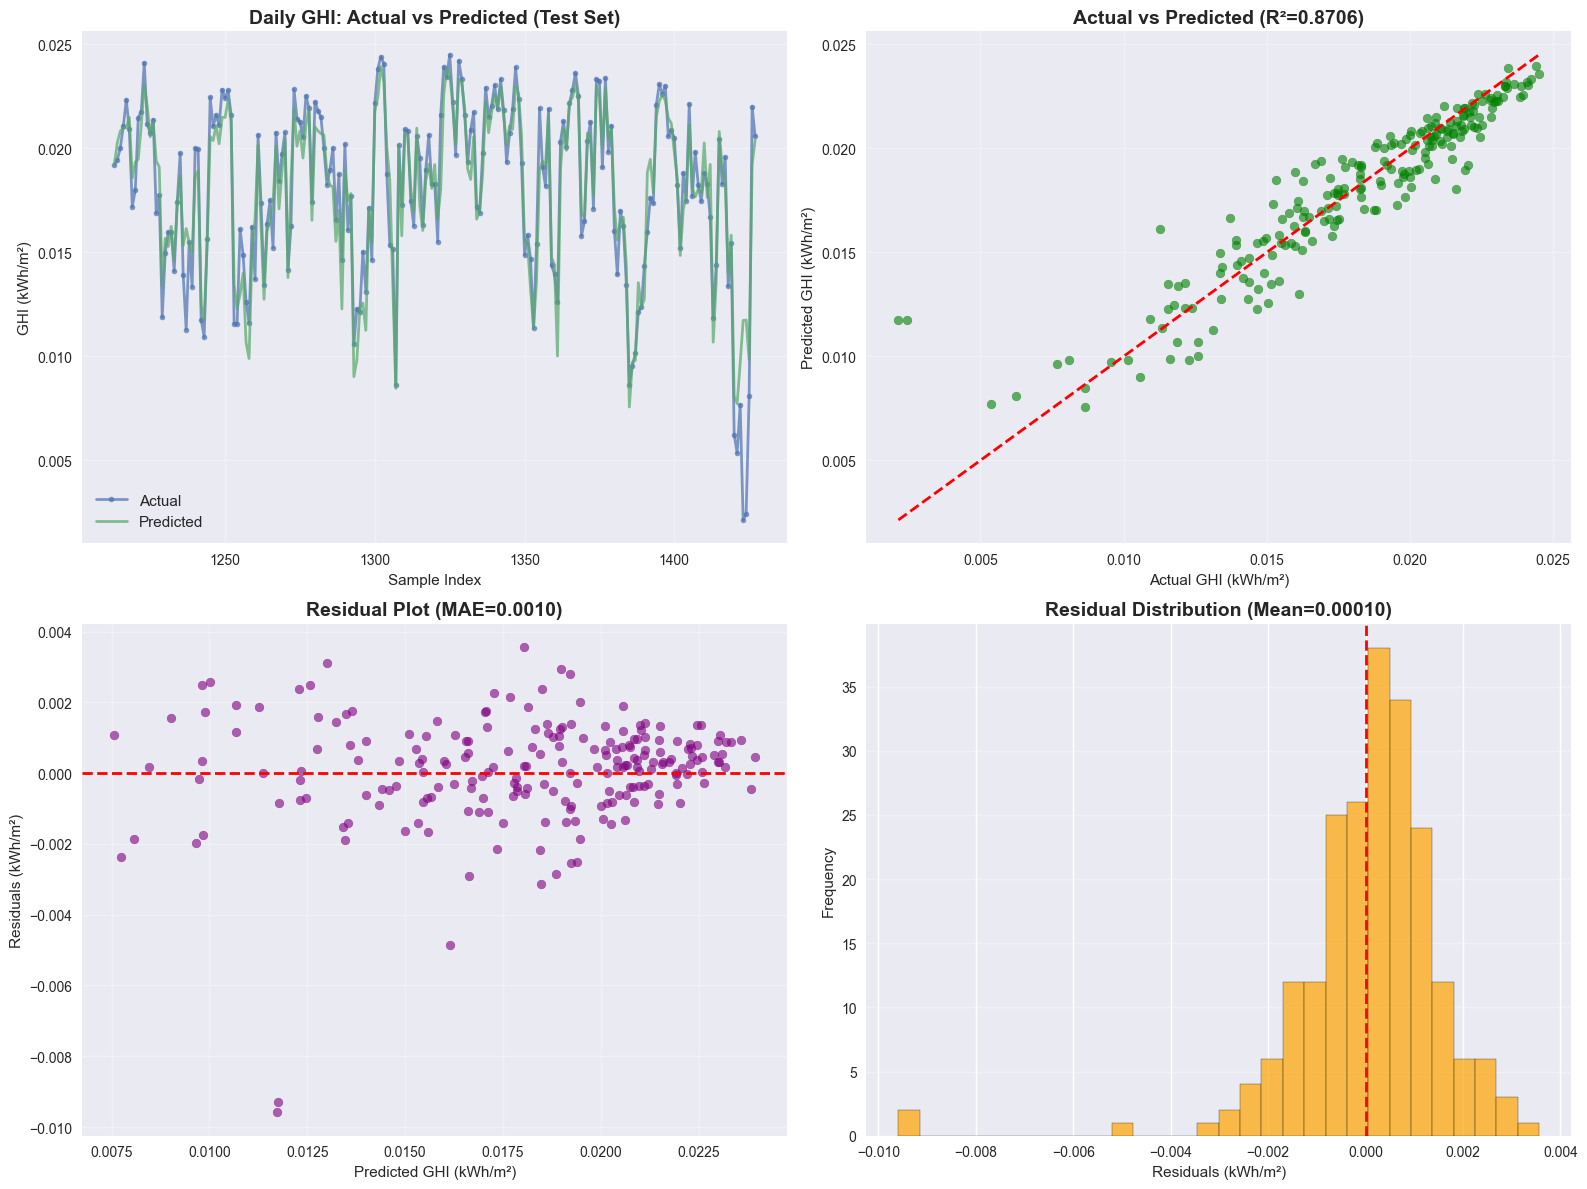

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Time series plot
axes[0, 0].plot(y_test.index, y_test.values, label='Actual', marker='o', linewidth=2, markersize=4, alpha=0.7)
axes[0, 0].plot(y_test.index, test_pred, label='Predicted', marker='x', linewidth=2, markersize=4, alpha=0.7)
axes[0, 0].set_title('Daily GHI: Actual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sample Index', fontsize=11)
axes[0, 0].set_ylabel('GHI (kWh/m²)', fontsize=11)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Scatter plot
axes[0, 1].scatter(y_test, test_pred, alpha=0.6, s=40, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual GHI (kWh/m²)', fontsize=11)
axes[0, 1].set_ylabel('Predicted GHI (kWh/m²)', fontsize=11)
axes[0, 1].set_title(f'Actual vs Predicted (R²={test_r2:.4f})', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test.values - test_pred
axes[1, 0].scatter(test_pred, residuals, alpha=0.6, s=40, color='purple')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted GHI (kWh/m²)', fontsize=11)
axes[1, 0].set_ylabel('Residuals (kWh/m²)', fontsize=11)
axes[1, 0].set_title(f'Residual Plot (MAE={test_mae:.4f})', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Error distribution
axes[1, 1].hist(residuals, bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals (kWh/m²)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title(f'Residual Distribution (Mean={np.mean(residuals):.5f})', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. Detailed Weather Lag Feature Analysis

Weather Lag Feature Categories - Importance Breakdown

Temperature Lag Features:
  temperature_max_lag1           0.0126
  temperature_max_lag2           0.0228
  temperature_max_lag3           0.0091
  temperature_min_lag1           0.0110
  temperature_min_lag2           0.0145
  temperature_min_lag3           0.0114
  temperature_max_roll3          0.0194
  temperature_min_roll3          0.0177
  Total: 0.1185

Precipitation Lag Features:
  precipitation_lag1             0.0074
  precipitation_lag2             0.0126
  precipitation_lag3             0.0077
  precipitation_roll3_sum        0.0121
  Total: 0.0398


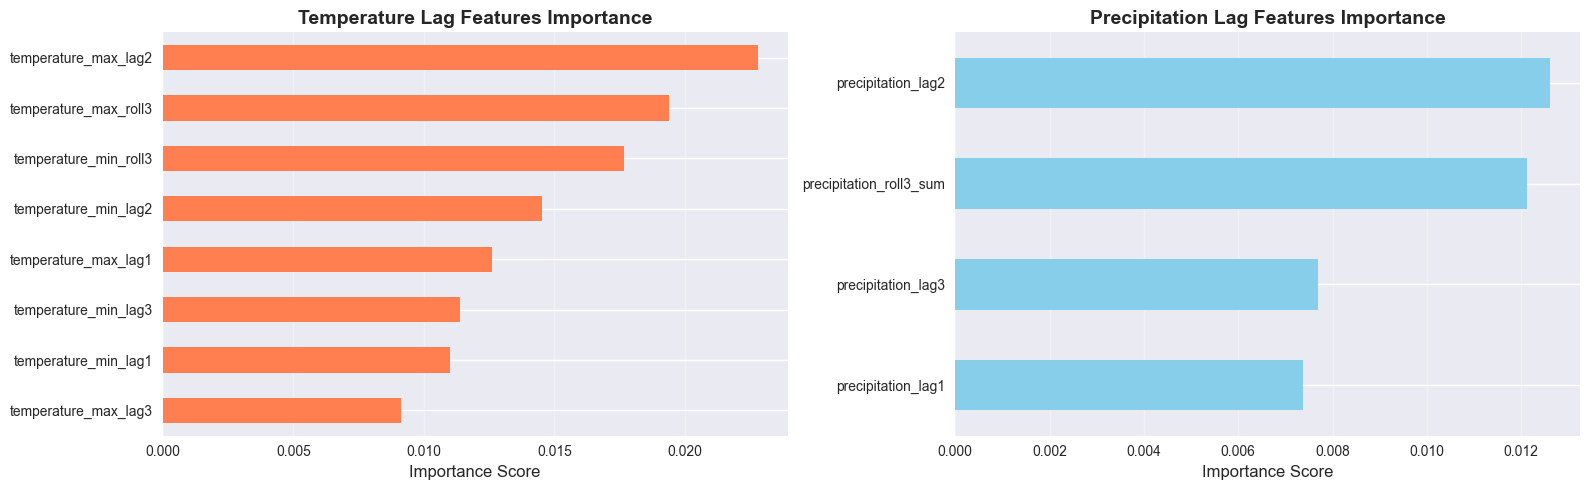

In [11]:
# Analyze each weather lag feature category
print('Weather Lag Feature Categories - Importance Breakdown')
print('='*60)

# Temperature lag features
temp_lag_features = [f for f in FEATURES if 'temperature_' in f and ('lag' in f or 'roll' in f)]
temp_lag_importance = importance[temp_lag_features]
print('\nTemperature Lag Features:')
for feat, imp in temp_lag_importance.items():
    print(f'  {feat:30s} {imp:.4f}')
print(f'  Total: {temp_lag_importance.sum():.4f}')

# Precipitation lag features
precip_lag_features = [f for f in FEATURES if 'precipitation_' in f and ('lag' in f or 'roll' in f)]
precip_lag_importance = importance[precip_lag_features]
print('\nPrecipitation Lag Features:')
for feat, imp in precip_lag_importance.items():
    print(f'  {feat:30s} {imp:.4f}')
print(f'  Total: {precip_lag_importance.sum():.4f}')

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Temperature lag features
temp_lag_importance.sort_values().plot(kind='barh', ax=ax1, color='coral')
ax1.set_title('Temperature Lag Features Importance', fontsize=14, fontweight='bold')
ax1.set_xlabel('Importance Score', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

# Precipitation lag features
precip_lag_importance.sort_values().plot(kind='barh', ax=ax2, color='skyblue')
ax2.set_title('Precipitation Lag Features Importance', fontsize=14, fontweight='bold')
ax2.set_xlabel('Importance Score', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Summary

### Experiment Objective:
Test if adding 3-day lag features for temperature and precipitation improves GHI forecasting accuracy.

### Features Added:
- Temperature max/min lag 1-3 days (6 features)
- Temperature max/min 3-day rolling average (2 features)
- Precipitation lag 1-3 days (3 features)
- Precipitation 3-day rolling sum (1 feature)
- **Total new features: 12**

### Key Findings:
(Results will be shown after running the notebook)

### Hypothesis:
Weather patterns often persist over multiple days. Historical temperature and precipitation data could help predict atmospheric conditions that affect solar irradiance, potentially improving GHI forecasts beyond what Kt lag features alone provide.